# Image Coloration 

Le but de ce travail est de transformer une image au niveau de gris en une image en couleur


In [ ]:
!pip install tensorflow==2.1

     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 3.9MB 56.6MB/s 
     |████████████████████████████████| 450kB 54.8MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=3be633918568293f2033b8f4220a5820601b34039351a8d6ce52b33c9bdf1240
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

# Fetch data

In [ ]:
!wget https://www.floydhub.com/api/v1/download/artifacts/data/MiXqoqaWLFhA5TNjJCiwoQ?is_dir=true&path=images

--2020-08-05 19:25:25--  https://www.floydhub.com/api/v1/download/artifacts/data/MiXqoqaWLFhA5TNjJCiwoQ?is_dir=true
Resolving www.floydhub.com (www.floydhub.com)... 172.67.72.144, 104.26.0.30, 104.26.1.30, ...
Connecting to www.floydhub.com (www.floydhub.com)|172.67.72.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘MiXqoqaWLFhA5TNjJCiwoQ?is_dir=true’

MiXqoqaWLFhA5TNjJCi     [             <=>    ] 681.18M  2.13MB/s    in 8m 32s  

2020-08-05 19:33:58 (1.33 MB/s) - ‘MiXqoqaWLFhA5TNjJCiwoQ?is_dir=true’ saved [714270720]



In [ ]:
!tar -xf "/content/MiXqoqaWLFhA5TNjJCiwoQ?is_dir=true" 

# Import des librairies

In [3]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

# Entrainement sur une image

In [1]:
path = "/content/images/"


In [66]:
p = path + 'Train/7CdRJg.jpg'
def traitement_image(path_to_img):

  # Get images
  image = img_to_array(load_img(path_to_img))
  image = np.array(image, dtype=float)
  width =  np.shape(image)[0]
  heigth =  np.shape(image)[1]

  # Import map images into the lab colorspace
  X = rgb2lab(1.0/255*image)[:,:,0]
  Y = rgb2lab(1.0/255*image)[:,:,1:]
  Y = Y / 128
  X = X.reshape(1, width, heigth, 1)
  Y = Y.reshape(1, width, heigth, 2)

  
  
  return((X , Y ,width , heigth))

X, Y , width, height = traitement_image(p) 

# Le reseau : autoencodeur Resnet18 + deconvolution layers

In [72]:
# Building the neural network
def define_network() : 
  model = Sequential()
  model.add(InputLayer(input_shape=(None, None, 1)))
  model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
  # Finish model
  model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])
  print(model.summary())
  return model

model = define_network()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, None, None, 8)     80        
_________________________________________________________________
conv2d_98 (Conv2D)           (None, None, None, 8)     584       
_________________________________________________________________
conv2d_99 (Conv2D)           (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_100 (Conv2D)          (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_101 (Conv2D)          (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_102 (Conv2D)          (None, None, None, 32)    9248      
_________________________________________________________________
up_sampling2d_27 (UpSampling (None, None, None, 32)   

# Entrainement 

In [73]:
#Train the neural network
history = model.fit(x=X, y=Y, batch_size=1, epochs=1500)
print(model.evaluate(X, Y, batch_size=1))

Epoch 1/1500
1/1 [==============================] - 0s 34ms/step - loss: 0.0064 - accuracy: 0.1779
Epoch 2/1500
1/1 [==============================] - 0s 31ms/step - loss: 0.0045 - accuracy: 0.9486
Epoch 3/1500
1/1 [==============================] - 0s 33ms/step - loss: 0.0044 - accuracy: 0.9519
Epoch 4/1500
1/1 [==============================] - 0s 33ms/step - loss: 0.0035 - accuracy: 0.9515
Epoch 5/1500
1/1 [==============================] - 0s 33ms/step - loss: 0.0028 - accuracy: 0.9518
Epoch 6/1500
1/1 [==============================] - 0s 28ms/step - loss: 0.0023 - accuracy: 0.9519
Epoch 7/1500
1/1 [==============================] - 0s 28ms/step - loss: 0.0019 - accuracy: 0.9519
Epoch 8/1500
1/1 [==============================] - 0s 30ms/step - loss: 0.0018 - accuracy: 0.9519
Epoch 9/1500
1/1 [==============================] - 0s 28ms/step - loss: 0.0017 - accuracy: 0.9519
Epoch 10/1500
1/1 [==============================] - 0s 26ms/step - loss: 0.0017 - accuracy: 0.9519
Epoch 11/

1/1 [==============================] - 0s 6ms/step - loss: 1.4975e-04 - accuracy: 0.9625
[0.00014974687655922025, 0.9625173211097717]


# Courbe d'evaluation

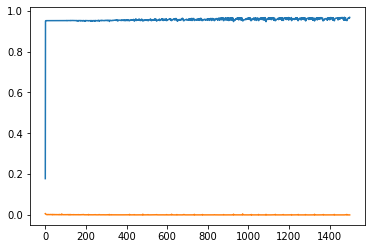

In [74]:
from matplotlib import pyplot as plt 

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

# Presentation des images

In [76]:
# Output colorizations
output = model.predict(X)
output = output * 128
canvas = np.zeros(( width, height, 3))
canvas[:,:,0] = X[0][:,:,0]
canvas[:,:,1:] = output[0]
imsave("img_result_2.png", lab2rgb(canvas))
imsave("img_gray_scale_2.png", rgb2gray(lab2rgb(canvas)))

#Image en gris

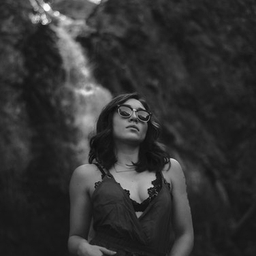

In [11]:
from IPython.display import Image
Image('img_gray_scale.png')

#Image en couleur

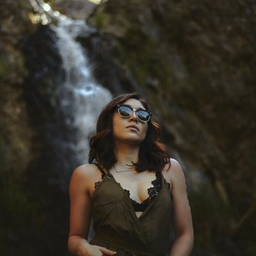

In [13]:
Image('img_result.png')


In [ ]:
np.shape(rgb2lab(1.0/255*image)[:,:,1:])

(256, 256, 2)

# Chargement du dataset

In [ ]:
# Recuperation des images 

X = []
cpt = 0
for filename in os.listdir(path+'Train/'):
  if cpt < 500 :
    X.append(img_to_array(load_img(path+'Train/'+filename)))
    cpt = cpt +1 
X = np.array(X, dtype=float)
Xtrain = 1.0/255*X

# Transfer Learning à partir d'un ResNet 18 

### Backbone

In [ ]:
#Load weights
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('/content/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.compat.v1.get_default_graph()



### Encodeur decodeur 

In [ ]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

### Train

In [ ]:
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 10

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)

#Train model      
tensorboard = TensorBoard(log_dir="/content/output")
model.compile(optimizer='adam', loss='mse')
model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard], epochs=1000, steps_per_epoch=20)

Instructions for updating:
Please use Model.fit, which supports generators.


ValueError: ignored

In [ ]:
tf.executing_eagerly()


True